# Eigenfaces - PCA on raw images

https://towardsdatascience.com/eigenfaces-face-classification-in-python-7b8d2af3d3ea

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report

## Load simple faces dataset

In [6]:
dataset_path = 'C:/Users/miros/Datasets/simple_faces/face_data.csv'

df = pd.read_csv(dataset_path)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.669422,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0


In [7]:
df.shape

(400, 4097)

So, 400 rows and 4097 columns, a strange combination. For the columns we here have normalized pixels values (meaning values in the range (0, 1)), and by the end we have a target column, indicating which person is on the photo.

If we take a closer look at the number of unique elements of the target column, we’d get the total number of people in the dataset:

In [8]:
df['target'].nunique()

40

And since we have 4096 features, it’s a clear indicator of **64x64** images in a single color channel: <br>

64 * 64 = 4096

## Image visualization

To visualize a couple of faces we’ll declare a function which transforms 1D vector to a 2D matrix, and uses Matplotlib’s imshow functionality to show it as a grayscale image:

In [10]:
def plot_faces(pixels):
    fig, axes = plt.subplots(5, 5, figsize=(6, 6)) # Create 5 rows and 5 columns of subplots
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.array(pixels)[i].reshape(64, 64), cmap='gray')
    plt.show()

But before plotting, we need to separate features from the target, otherwise, our dataset will overflow the 64x64 matrix boundaries:

In [11]:
X = df.drop('target', axis=1)
y = df['target']

In [12]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.665289,0.669422,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.136364,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.074380,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.652893,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.190083,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554


In [13]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

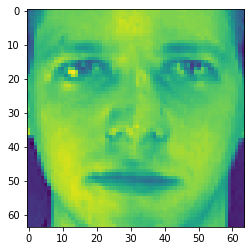

In [37]:
# View image from the dataset:

image = np.array(X.iloc[0]) # Select first row from the pandas dataframe (each row is one flattened image of 4096 pixels)

image_reshape = image.reshape(64, 64) # Reshape 4096 into image with 64x64 shape

# Visualize image
plt.imshow(image_reshape)
plt.show()

## Principal Component Analysis

The goal of this section is to reduce the dimensionality of our problem by keeping only those components that explain the most variance. That in a nutshell is a goal of PCA. But before doing so, we must split the dataset into training and testing portions:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
print(len(X_train))

300


In [16]:
print(len(X_test))

100


Now we can apply the PCA on the training features. Then it’s easy to plot the cumulative sum of the explained variance, so we can approximate how many principal components are enough:

In [17]:
# Apply PCA on training data
pca = PCA().fit(X_train)

In [18]:
print(type(pca))

<class 'sklearn.decomposition._pca.PCA'>


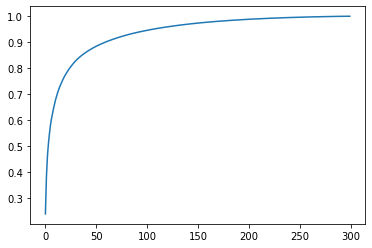

In [21]:
plt.plot(pca.explained_variance_ratio_.cumsum())

Just by looking at the chart, it seems like around 100 principal components will keep around 95% of the variance, but let’s verify that claim:

In [22]:
np.where(pca.explained_variance_ratio_.cumsum() > 0.95)

(array([106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
        197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
        210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
        223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
        236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248,
        249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261,
        262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274,
        275, 276, 277, 278, 279, 280, 281, 282, 283

Yes, it looks like 105 components will do the trick. Keep in mind that 95% isn’t set in stone, keep free to go for lower or higher percent on your own.

Let’s perform the PCA again, but this time with additional **n_components** argument:

In [25]:
pca = PCA(n_components=105).fit(X_train)

And finally, we must transform the training features using **`transform(X)`** method. This method applies dimensionality reduction to X. X is projected on the first principal components previously extracted from a training set.

When you call fit PCA is going to compute some vectors that you can project your data onto in order to reduce the dimension of your data. The first of those vectors will maximize the variance of the projected data. The 2nd will maximize the variance of what's left after the first projection. Typically one passed a value of `n_components` that's less than the dimension of the input data so that you get back fewer rows and you have a wide but not tall `components_` array.

When you call transform you're asking sklearn to actually do the projection. That is, you are asking it to project each row of your data into the vector space that was learned when fit was called. For each row of the data you pass to transform you'll have 1 row in the output and the number of columns in that row will be the number of vectors that were learned in the fit phase. In other words, the number of columns will be equal to the value of `n_components` you passed to the constructor.

Typically one uses PCA when the source data has lots of columns and you want to reduce the number of columns while preserving as much information as possible. Suppose you had a data set with 100 rows and each row had 500 columns. If you constructed a PCA like PCA(n_components = 10) and then called fit you'd find that components_ has 10 rows, one for each of the components you requested, and 500 columns as that's the input dimension. If you then called transform all 100 rows of your data would be projected into this 10-dimensional space so the output would have 100 rows (1 for each in the input) but only 10 columns thus reducing the dimension of your data.

In [26]:
X_train_pca = pca.transform(X_train)

In [27]:
print(X_train)

            0         1         2         3         4         5         6  \
159  0.545455  0.574380  0.586777  0.590909  0.595041  0.632231  0.640496   
203  0.466942  0.479339  0.483471  0.483471  0.504132  0.549587  0.574380   
80   0.500000  0.487603  0.537190  0.574380  0.595041  0.595041  0.628099   
269  0.384298  0.508265  0.619835  0.723140  0.764463  0.776860  0.797521   
61   0.305785  0.305785  0.549587  0.665289  0.657025  0.673554  0.677686   
..        ...       ...       ...       ...       ...       ...       ...   
33   0.508265  0.603306  0.619835  0.628099  0.657025  0.665289  0.690083   
184  0.338843  0.458678  0.681818  0.772727  0.785124  0.814050  0.838843   
231  0.446281  0.495868  0.524793  0.528926  0.524793  0.528926  0.528926   
154  0.586777  0.702479  0.731405  0.731405  0.743802  0.772727  0.793388   
319  0.471074  0.557851  0.644628  0.578512  0.409091  0.603306  0.743802   

            7         8         9  ...      4086      4087      4088  \
159